In [1]:
import retro
from gym import Env
from gym.spaces import MultiBinary, Box, Discrete
import numpy as np
import cv2
from matplotlib import pyplot as plt    

In [2]:
class StreetFighter(Env):
    def __init__(self,game_state='Champion.Level1.RyuVsGuile.state'):
        super().__init__()
        self.observation_space = Box(low=0,high=255,shape=(84,84,1), dtype=np.uint8)
        self.action_space = Discrete(2**12)
        self.game = retro.make(game='StreetFighterII-Champion', state=game_state,use_restricted_actions=retro.Actions.DISCRETE)

    def step(self, action):
        obs, reward, done, info = self.game.step(action)
        obs = self.preprocess(obs)
        frame_delta = obs - self.previous_frame
        self.previous_frame = obs
        reward = info['score'] - self.score
        self.score = info['score']
        return frame_delta, reward, done, info

    def render(self,*args,**kwargs):
        self.game.render()

    def reset(self):
        obs = self.game.reset()
        obs = self.preprocess(obs)
        self.previous_frame = obs
        self.score = 0
        return obs

    def preprocess(self, observation):
        gray = cv2.cvtColor(observation, cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (84,84), cv2.INTER_CUBIC)
        channels = np.reshape(resize, (84,84,1))
        return channels

    def close(self):
        self.game.close()

In [147]:
env.close()

In [119]:
env = StreetFighter()

In [121]:
obs = env.reset()
action = env.action_space.sample()
while True:
    state, reward, done, info = env.step(action)
    # if reward != 0:
    #     print(reward)
    #     print(info)
    env.render()
    if done:
        break
    action = env.action_space.sample()
env.close()

In [4]:
import optuna
import os
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [12]:
LOG_DIR = './logs/DQN'
OPT_DIR = './opt/DQN'

In [6]:
def optimize(trial):
    return {
        'learning_rate':trial.suggest_loguniform('learning_rate',1e-5,1e-4),
        'gamma':trial.suggest_loguniform('gamma', 0.8,0.9999),
        'tau':trial.suggest_loguniform('tau', 0.001,0.01),
    }

In [145]:
env.close()

In [7]:
def optimize_agent(trial):
    try:
        model_params = optimize(trial)
        env = StreetFighter()
        env = Monitor(env,LOG_DIR)
        env = DummyVecEnv([lambda: env])
        env = VecFrameStack(env,4,channels_order='last')

        model = DQN("CnnPolicy",env,tensorboard_log=LOG_DIR,verbose=0,batch_size=216,buffer_size=80000, **model_params) # cnn policy uses conv neural net for 
        model.learn(total_timesteps=10000)

        mean_reward, _ = evaluate_policy(model,env,n_eval_episodes=10)
        env.close()
        
        SAVE_PATH = os.path.join(OPT_DIR, 'trial_{}_best_model'.format(trial.number))
        model.save(SAVE_PATH)
        print(mean_reward)
        
        return mean_reward
    except Exception as e:
        print(e)
        return -1000

In [8]:
study = optuna.create_study(direction='maximize')
study.optimize(optimize_agent,n_trials=10,n_jobs=1)

[I 2024-04-19 00:36:43,625] A new study created in memory with name: no-name-8d3595e5-4e23-4ca2-9e57-36258f10500d
c:\Users\reece\anaconda3\envs\streetfighter37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\reece\anaconda3\envs\streetfighter37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  after removing the cwd from sys.path.
c:\Users\reece\anaconda3\envs\streetfighter37\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be r

KeyboardInterrupt: 

In [10]:
study.best_trial

FrozenTrial(number=0, state=TrialState.COMPLETE, values=[43000.0], datetime_start=datetime.datetime(2024, 4, 17, 1, 43, 36, 768013), datetime_complete=datetime.datetime(2024, 4, 17, 1, 53, 32, 165284), params={'learning_rate': 1.0441637166392424e-05, 'gamma': 0.8747694471766431, 'tau': 0.004366731241391021}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.0001, log=True, low=1e-05, step=None), 'gamma': FloatDistribution(high=0.9999, log=True, low=0.8, step=None), 'tau': FloatDistribution(high=0.01, log=True, low=0.001, step=None)}, trial_id=0, value=None)

In [11]:
study.best_params

{'learning_rate': 1.0441637166392424e-05,
 'gamma': 0.8747694471766431,
 'tau': 0.004366731241391021}

In [39]:
import numpy as np
import gym

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory

In [41]:
env.close()

In [ ]:
def Q_Learning(
        env, # openai gym environment
        alpha:float, # step size
        gamma:float,
        num_episode:int
) -> np.array:
    def epsilon_greedy_policy(s,done,w,epsilon=.0):
        nA = env.action_space.n
        Q = [np.dot(w, X(s,done,a)) for a in range(nA)]

        if np.random.rand() < epsilon:
            return np.random.randint(nA)
        else:
            return np.argmax(Q)
        

    # Loop for each episode
    for ep in range(num_episode):
        state = env.reset()
        
        while True:
            
        # Loop until terminal

            # Choose action from S using policy derived from Q

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=180)

c:\Users\reece\anaconda3\envs\streetfighter37\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))
MovieWriter imagemagick unavailable; using Pillow instead.


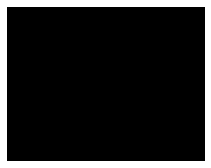

: 

In [8]:
"""
Ensure you have imagemagick installed with 
sudo apt-get install imagemagick
Open file in CLI with:
xgd-open <filelname>
"""

            # update Q

            # update S